
# 使用Gensim

<br>


　gemsim是一个主题模型Python工具库，能够从文档中有效地自动抽取语义主题。gensim中的算法包括：LSA(Latent Semantic Analysis), LDA(Latent Dirichlet Allocation), RP (Random Projections),word2vec 通过在一个训练文档语料库中，检查词汇统计联合出现模式, 可以用来发掘文档语义结构，这些算法属于非监督学习，可以处理原始的，非结构化的文本(plain text)。

在此，使用LDA和word2vec进行实践。



![gensim](img/news007_00.jpg)




## 下载数据/预处理



### 文本分类标准测试集reuters-21578


.. _`Reuters-21578`: http://www.daviddlewis.com/resources/testcollections/reuters21578/



　`Reuters-21578`_ 是一个开放数据集，用于文本分类研究的测试集合。是路透社过去有关金融新闻的文章集。


### 什么是NLTK？


　NLTK（Python自然语言工具包）用于诸如标记化、词形还原、词干化、解析、POS标注等任务。该库具有几乎所有NLP任务的工具。


### 利用NLTK下载




In [3]:
import matplotlib.pyplot as plt
%matplotlib inline
import gensim
import nltk
nltk.download("reuters")
nltk.download("stopwords")
nltk.download("punkt")



[nltk_data] Downloading package reuters to /root/nltk_data...
[nltk_data]   Package reuters is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True


　有连续三个nltk.download，nltk.download(reuters)是Reuters-21578数据。另外两个nltk.downloads下载数据供以后使用。将下载的文件保存在适当的本地目录中。



### 读取数据并存于变量中


In [4]:
reuters = nltk.corpus.reuters
paras = reuters.paras()



　从文件中读取Reuters-21578数据，存于reuters中。

　reuters中有各种信息的对象，新闻记事的文本信息通过paras方法获取。
paras[i]中的第i条指向一个句子，每条是一个句子的列表，每句是单词列表。

　看一下第一篇文章中第一句话的20个单词。


In [5]:
paras[0][0][:20]

['ASIAN',
 'EXPORTERS',
 'FEAR',
 'DAMAGE',
 'FROM',
 'U',
 '.',
 'S',
 '.-',
 'JAPAN',
 'RIFT',
 'Mounting',
 'trade',
 'friction',
 'between',
 'the',
 'U',
 '.',
 'S',
 '.']

　在Gensim中使用「bag of words」“词袋”形式的文档。所谓的单词袋形式是一种忽略单词的排列方式的数据格式，只保留有关文档中每个单词出现次数的信息。



### 去除停用词




　有一点需要注意。通常在自然语言处理中，去除停用词是预处理工作。停用词是指，经常使用但实际上不影响句子解释的词。如在英语中的冠词和介词等。这些是是人们阅读英语句子时的重要信息，但在不考虑单词顺序单词袋中，就变成了无用的信息。

　看一下NLTK中的英语停用词。


In [6]:
stop_words = set(nltk.corpus.stopwords.words("english"))

下面是英文字母顺序的前十个停用词。

In [7]:
sorted(stop_words)[:10]

['a', 'about', 'above', 'after', 'again', 'against', 'ain', 'all', 'am', 'an']


### 将数据转换为“词序列”



 把文档数据转换为“字符串双重列表”。换句话说，就是把每篇文章原有“段落”结构，转换为单纯的“单词序列”。


In [8]:
import itertools
reuters_texts = [itertools.chain(*p) for p in paras]
reuters_texts_filtered = [[w.lower() for w in p if w not in stop_words and len(w) >= 2] for p in reuters_texts]



　reuters_texts变量存放结果，而去除了停用词和单一字母单词的结果存于reuters_texts_filtered中，


### 转换为Corpus(语料库)格式



　转换为Gensim中使用的“语料库”格式。语料库是自然语言处理中经常使用的术语，通常定义为易于进行文章的构造化结构。Gensim中是语料库的单袋格式。


In [9]:
dictionary = gensim.corpora.Dictionary(itertools.chain(reuters_texts_filtered))
reuters_corpus = [dictionary.doc2bow(text) for text in reuters_texts_filtered]


　gensim.corpora.Dictionary是对每个单词的数值定义的类型。该类型能够进行单词和数字的双向转换。第二行是利用它制作一套单词格式的语料库。显示reuters_corpus中第一个文档的10个单词。


In [10]:
reuters_corpus[0][:10]

[(0, 1),
 (1, 6),
 (2, 1),
 (3, 1),
 (4, 2),
 (5, 1),
 (6, 1),
 (7, 1),
 (8, 1),
 (9, 1)]



（0，1），（1，6）表示指第0个单词出现1次，第1个单词出现6次。

到此为止是预处理部分，下面使用机器学习进行分析。



## 使用LDA计算主题模型



### 什么是LDA


　LDA是“主题模型”的手法之一。主题模型是指推测文档主题的模型，用于文档分类和搜索。 LDA通过“概率分布”预测每个文档的主题。

　如，假设新闻网站包含三个主题的要素：“政治”，“经济”和“体育”。LDA分析得到的是三项要素的加权值。如果将其标准化总和为 1，则可以将LDA视为这三个主题的概率分布。

　下图显示的是计算结果。


![ss](img/news007_1.jpg)


在LDA中，从指定主题的数量。然后得到“有哪些主题”，并计算每个文档的主题分布。


### LDA训练



In [11]:
dictionary[0]
model=gensim.models.ldamodel.LdaModel(reuters_corpus, num_topics=20,id2word=dictionary.id2token, random_state=0)



　dictionary[0]是函数dictionary.id2token所需的手续。在第二行中，建立模型并训练。参数num_topics是主题数，参数id2word是数字/单词的转换函数。之后的可视化中需要。 Random_state是随机数种子，用于多次执行提高结果的再现度。



In [12]:
model.print_topics()

[(0,
  '0.052*"bank" + 0.037*"mln" + 0.034*"stg" + 0.023*"said" + 0.018*"the" + 0.015*"market" + 0.013*"pct" + 0.011*"money" + 0.011*"billion" + 0.011*"dlrs"'),
 (1,
  '0.032*"pct" + 0.025*"said" + 0.024*"billion" + 0.016*"the" + 0.013*"year" + 0.010*"bank" + 0.007*"government" + 0.007*"trade" + 0.007*"foreign" + 0.007*"last"'),
 (2,
  '0.028*"lt" + 0.023*"said" + 0.017*"inc" + 0.017*"corp" + 0.015*"dlrs" + 0.015*"mln" + 0.012*"unit" + 0.012*"co" + 0.009*"company" + 0.008*"division"'),
 (3,
  '0.044*"said" + 0.028*"company" + 0.020*"dlrs" + 0.013*"lt" + 0.012*"share" + 0.011*"the" + 0.010*"inc" + 0.008*"offer" + 0.008*"would" + 0.007*"mln"'),
 (4,
  '0.046*"january" + 0.044*"billion" + 0.041*"february" + 0.032*"dlrs" + 0.031*"pct" + 0.027*"mln" + 0.023*"year" + 0.021*"rose" + 0.017*"1986" + 0.016*"december"'),
 (5,
  '0.024*"said" + 0.017*"dlrs" + 0.014*"the" + 0.014*"year" + 0.011*"mln" + 0.008*"pct" + 0.008*"bank" + 0.007*"banks" + 0.006*"company" + 0.006*"week"'),
 (6,
  '0.063*"cts

　对于每个主题，以单词和权重的最高顺序排列。第0个主题中bank和million权重高，可以视为是银行相关的主题。第三个主题中公司，dlrs，股票的权重高，可以看作是有关公司股价的主题。



### 推测主题



　使用和训练相同的数据，推测文档主题。

In [13]:
pred, _ = model.inference(reuters_corpus)
pred /= pred.sum(axis=1).reshape(-1, 1)



　第一行是计算预测值。第二行对结果正规化。

　用条形图可视化前5个文档的主题分布。


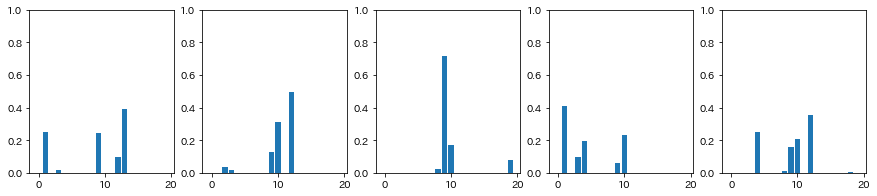

In [14]:
fig, axes = plt.subplots(1, 5, figsize=(15, 3))
for i in range(5):
    axes[i].set_ylim(0, 1)
    axes[i].bar(range(20), pred[i])



　第一个是文档中信息最强烈的主题

In [15]:
pred[0].argmax()

13

　从上面的主题构成词列表中查找第13个主题，会发现诸如“交易”和“协议”之类的权重很高。推测，与国际贸易协定有关。让我们看一下文档（仅显示前300个字符）。


In [16]:
fileids = reuters.fileids()
print(reuters.raw(fileids[0])[:300])



ASIAN EXPORTERS FEAR DAMAGE FROM U.S.-JAPAN RIFT
  Mounting trade friction between the
  U.S. And Japan has raised fears among many of Asia's exporting
  nations that the row could inflict far-reaching economic
  damage, businessmen and officials said.
      They told Reuter correspondents in Asian 


　这是关于日美贸易摩擦的新闻。事实证明，LDA判决是合理的。




## Word2vec词嵌入



### 下载Quora数据集



　下载数据"quora_duplicate_questions.tsv”, 将其放在目录"data"中。
以其中的"question1"为列。它收集了大约40万个英语问题。
读取数据，分解为单词，显示前10个句子的内容。

In [17]:
import csv
quora = []
with open("data/quora_duplicate_questions.tsv", encoding='utf-8') as fp:
    reader = csv.reader(fp, delimiter="\t")
    next(reader)
    for row in reader:
        quora.append(nltk.tokenize.word_tokenize(row[3].lower()))
print(quora[:10])



[['what', 'is', 'the', 'step', 'by', 'step', 'guide', 'to', 'invest', 'in', 'share', 'market', 'in', 'india', '?'], ['what', 'is', 'the', 'story', 'of', 'kohinoor', '(', 'koh-i-noor', ')', 'diamond', '?'], ['how', 'can', 'i', 'increase', 'the', 'speed', 'of', 'my', 'internet', 'connection', 'while', 'using', 'a', 'vpn', '?'], ['why', 'am', 'i', 'mentally', 'very', 'lonely', '?', 'how', 'can', 'i', 'solve', 'it', '?'], ['which', 'one', 'dissolve', 'in', 'water', 'quikly', 'sugar', ',', 'salt', ',', 'methane', 'and', 'carbon', 'di', 'oxide', '?'], ['astrology', ':', 'i', 'am', 'a', 'capricorn', 'sun', 'cap', 'moon', 'and', 'cap', 'rising', '...', 'what', 'does', 'that', 'say', 'about', 'me', '?'], ['should', 'i', 'buy', 'tiago', '?'], ['how', 'can', 'i', 'be', 'a', 'good', 'geologist', '?'], ['when', 'do', 'you', 'use', 'シ', 'instead', 'of', 'し', '?'], ['motorola', '(', 'company', ')', ':', 'can', 'i', 'hack', 'my', 'charter', 'motorolla', 'dcx3400', '?']]


　去除停用词，显示前10个句子。

In [18]:
quora_filtered = []
for sentence in quora:
    quora_filtered.append([w for w in sentence if w not in stop_words and len(w) > 1])
print(quora_filtered[:10])


[['step', 'step', 'guide', 'invest', 'share', 'market', 'india'], ['story', 'kohinoor', 'koh-i-noor', 'diamond'], ['increase', 'speed', 'internet', 'connection', 'using', 'vpn'], ['mentally', 'lonely', 'solve'], ['one', 'dissolve', 'water', 'quikly', 'sugar', 'salt', 'methane', 'carbon', 'di', 'oxide'], ['astrology', 'capricorn', 'sun', 'cap', 'moon', 'cap', 'rising', '...', 'say'], ['buy', 'tiago'], ['good', 'geologist'], ['use', 'instead'], ['motorola', 'company', 'hack', 'charter', 'motorolla', 'dcx3400']]


### 什么是Word2vec



词嵌入(Word Embedding)：

  就是将「不可计算」「非结构化」的词转化为「可计算」「结构化」的向量,这一步解决的是”将现实问题转化为数学问题“
Word2vec是词嵌入方式之一，属于NLP领域。将词转化为「可计算」「结构化」的向量的过程。

　Word2vec是一种将词嵌入到指定维度空间中的算法，空间中单词之间距离的接近度就是单词含义的接近度。


### 使用Word2vec训练



　与LDA不同，仅需要单词列表，而不需要语料库数据。

In [19]:
model = gensim.models.Word2Vec(quora_filtered, size=50, window=5)


　此处指定的“size”是嵌入维度空间的尺寸，“窗口”是连接单词数。


### 使用Word2vec推测


　看一下训练后的模型中的与“生病”和“演员”两个词相近的词。

In [20]:
model.wv.similar_by_word("sick")


/root/anaconda3/envs/ml-dev/lib/python3.5/site-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('angry', 0.8846410512924194),
 ('hungry', 0.8809215426445007),
 ('pierced', 0.8643348217010498),
 ('uncomfortable', 0.8594077229499817),
 ('dizzy', 0.8556342720985413),
 ('drunk', 0.8525719046592712),
 ('depressed', 0.8452755212783813),
 ('jealous', 0.8409408330917358),
 ('aroused', 0.8362992405891418),
 ('horny', 0.8306034803390503)]

　单词从上到下按顺序排列。可以结果是合理的。


In [21]:
model.wv.similar_by_vector("actor")


[('actress', 0.92546546459198),
 ('singer', 0.8973912596702576),
 ('bollywood', 0.8659350872039795),
 ('actors', 0.8614586591720581),
 ('superhero', 0.8529343008995056),
 ('actor/actress', 0.8393876552581787),
 ('comedy', 0.8310166597366333),
 ('portrayed', 0.8223127126693726),
 ('actresses', 0.8207921385765076),
 ('hollywood', 0.81743323802948)]


## 总结



　演示Gensim的典型用法，LDA和Word2vec。这些可以用来和主题模型的类似的领域比如文档检索。
　处理的是英文数据，在中文，日文中处理时，还需要构词分割等工具。比较知名的有MeCab、Juman、Sudachi等。


## 结束语


　广泛而浅显介绍了机器学习中使用各种工具库，在库的选择上，是基于作者本身的经验，可能有所偏颇。希望读者通过学习，对Python机器学习中各种工具库的使用有一个宏观明确的认识。

